In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
model_path = 'pose_landmarker_lite.task'

In [3]:
import cv2
import numpy as np
import os

In [4]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

In [5]:
image = cv2.imread('test.jpg') 
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
image_height, image_width, _ = image.shape

In [17]:
results = pose.process(image_rgb)
if results.pose_landmarks:
    keypoints_pixel = [
        (int(lm.x * image_width), int(lm.y * image_height)) 
        for lm in results.pose_landmarks.landmark
    ]
else:
    keypoints_pixel = []


In [ ]:
# Draw pose landmarks on the image.
annotated_image = image.copy()
mp_drawing.draw_landmarks(
    annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

cv2.imshow('MediaPipe Pose', annotated_image)
cv2.waitKey(0)

113

: 

In [18]:
def generate_heatmap(image_size, keypoints, sigma=10):
    """
    Tạo bản đồ nhiệt từ keypoints.

    Args:
        image_size (tuple): Kích thước ảnh (height, width).
        keypoints (list): Danh sách tọa độ keypoints [(x, y), ...].
        sigma (int): Độ lan rộng của Gaussian blob.

    Returns:
        heatmap (numpy array): Bản đồ nhiệt (height, width).
    """
    heatmap = np.zeros(image_size, dtype=np.float32)
    for x, y in keypoints:
        tmp = np.zeros(image_size, dtype=np.float32)
        cv2.circle(tmp, (int(x), int(y)), radius=sigma, color=1, thickness=-1)
        tmp = cv2.GaussianBlur(tmp, (0, 0), sigma)
        heatmap = np.maximum(heatmap, tmp)  # Kết hợp blob
    return heatmap

In [19]:
heatmap = generate_heatmap((image_height, image_width), keypoints_pixel, sigma=20)

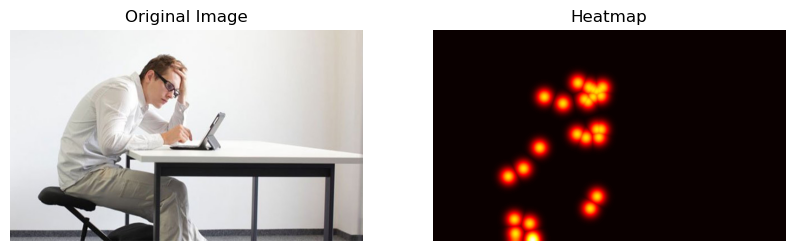

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap')
plt.axis('off')

plt.show()


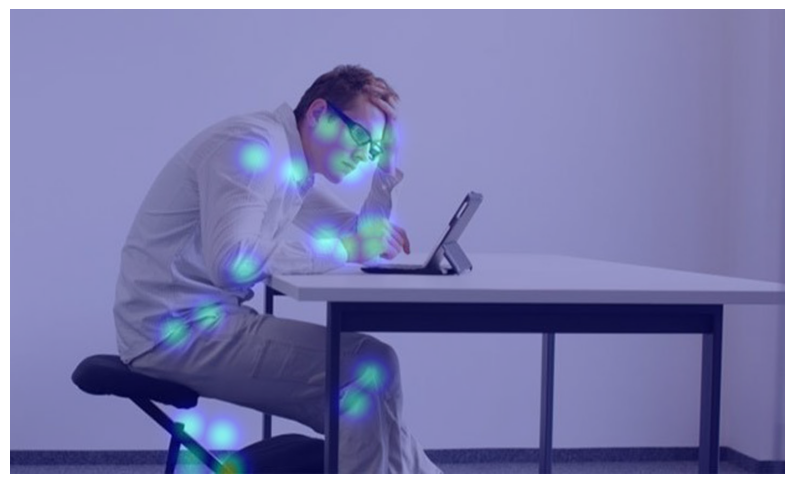

In [ ]:
heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 10))
plt.imshow(overlay[:, :, ::-1])
plt.axis('off')
plt.show()


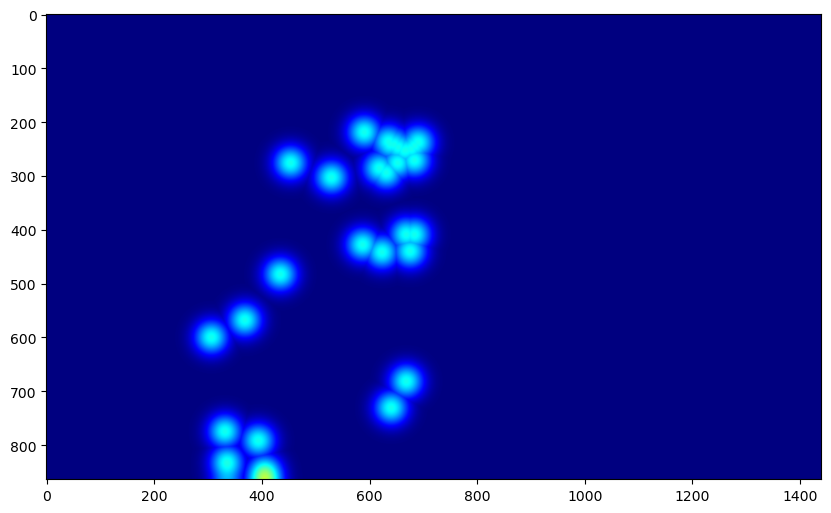

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap_color[:, :, ::-1], cmap='hot')

In [ ]:
import cv2
import os

input_folder = "videos"
output_folder = "images"

os.makedirs(output_folder, exist_ok=True)


for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue 

    output_class_path = os.path.join(output_folder, class_name)
    os.makedirs(output_class_path, exist_ok=True)


    for video_name in os.listdir(class_path):
        video_path = os.path.join(class_path, video_name)
        if not video_name.endswith(('.mp4', '.avi', '.mov', '.mkv')): 
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Không thể mở video: {video_path}")
            continue
        video_base_name = os.path.splitext(video_name)[0]

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_filename = f"{output_class_path}/{video_base_name}_frame_{frame_count:04d}.jpg"
            cv2.imwrite(frame_filename, frame)
            frame_count += 1

        cap.release()
        print(f"Đã xử lý video: {video_path}, lưu {frame_count} frames vào {output_class_path}")

print("Hoàn tất xử lý tất cả video!")


KeyboardInterrupt: 

In [7]:
import json
def extract_keypoints(image_path, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        keypoints = []
        for lm in result.pose_landmarks.landmark:
            keypoints.append([lm.x, lm.y, lm.visibility])
        return keypoints
    return None

In [7]:
def process_folder(input_dir, output_dir):
    """
    Process all images in a folder and save extracted keypoints as JSON files.

    Args:
        input_dir (str): Path to the folder containing images.
        output_dir (str): Path to the folder to save JSON files.
    """
    os.makedirs(output_dir, exist_ok=True)
    for file_name in os.listdir(input_dir):
        if file_name.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(input_dir, file_name)
            keypoints = extract_keypoints(image_path)
            if keypoints:
                json_path = os.path.join(output_dir, file_name.replace('.jpg', '.json'))
                with open(json_path, 'w') as f:
                    json.dump(keypoints, f)
            else:
                print(f"Skipping {file_name}, no keypoints detected.")
                os.remove(image_path)

In [ ]:

base_dir = "images"
output_dir = "keypoints_dataset"
for label in ["true", "false"]:
    input_path = os.path.join(base_dir, label)
    output_path = os.path.join(output_dir, label)
    try:
        process_folder(input_path, output_path)
    except Exception as e:
        print("Error processing:", input_path)

Error processing: images\true
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0286.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0543.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0544.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0591.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0764.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0765.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0768.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0769.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0770.jpg, no keypoints detected.
Skipping 467872293_8699886063430643_121767301482093286_n_frame_0798.jpg, no keypoints detected.
Skipping 4

In [ ]:

for label in ["true", "false"]:
    input_path = os.path.join(base_dir, label)
    for file_name in os.listdir(input_path):
        if file_name.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(input_path, file_name)
            keypoints = extract_keypoints(image_path)
            if not keypoints:
                os.remove(image_path)
                print(f"Deleted {image_path}")

Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0004.jpg
Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0005.jpg
Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0006.jpg
Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0007.jpg
Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0009.jpg
Deleted images\true\468196966_8753536961400135_757487208913306547_n_frame_0010.jpg


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
import numpy as np

def normalize_keypoints(keypoints, confidence_threshold=0.5):
    """
    Normalize keypoints: translation to origin and scale normalization.

    Args:
        keypoints (list): A list of keypoints [x, y, confidence].
        confidence_threshold (float): Minimum confidence to include keypoints.

    Returns:
        numpy.ndarray: Normalized keypoints of shape (33, 3).
    """
    keypoints = np.array(keypoints)
    mask = keypoints[:, 2] >= confidence_threshold 
    keypoints[~mask, :2] = 0 

    if mask.sum() > 0:
        hips = keypoints[[11, 12], :2] 
        if np.all(mask[[11, 12]]): 
            center = hips.mean(axis=0)
        else:
            center = keypoints[mask, :2].mean(axis=0)
        keypoints[:, :2] -= center

    # Scale normalization
    distances = np.linalg.norm(keypoints[mask, :2], axis=1)
    max_distance = distances.max() if distances.size > 0 else 1
    keypoints[:, :2] /= max_distance

    return keypoints
